In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import numpy as np
import matplotlib.pyplot as plt

### Wandb login

In [6]:
!pip install wandb --quiet

In [7]:
import wandb
wandb.login(key="YOU_API_KEY")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/Dell/.netrc


True

### Get the stock_prediction dataframe

In [10]:
stock_prediction_df = pd.read_csv('Code/baseline-implementation/stock_prediction.csv')
stock_prediction_df.drop(columns=['Unnamed: 0'],inplace=True)
stock_prediction_df.head()

,Date,sentiment,PriceDiff
0,2016-01-05,0.400000,-0.459333
1,2016-01-06,0.200000,-0.971214
2,2016-01-07,0.111111,0.116552
3,2016-01-08,0.400000,0.358770
4,2016-01-11,0.400000,0.326792


### Feature Engineering

In [11]:
# Create lagged features for the price_diff values
for i in range(1, 8):
    stock_prediction_df[f'PriceDiff_{i}'] = stock_prediction_df['PriceDiff'].shift(i)

# Remove missing values
stock_prediction_df.dropna(inplace=True)
stock_prediction_df.head()

,Date,sentiment,PriceDiff,PriceDiff_1,PriceDiff_2,PriceDiff_3,PriceDiff_4,PriceDiff_5,PriceDiff_6,PriceDiff_7
7,2016-01-14,0.20,-0.546173,0.486757,-0.587307,0.326792,0.358770,0.116552,-0.971214,-0.459333
8,2016-01-15,0.75,-0.107401,-0.546173,0.486757,-0.587307,0.326792,0.358770,0.116552,-0.971214
9,2016-01-19,0.50,0.029711,-0.107401,-0.546173,0.486757,-0.587307,0.326792,0.358770,0.116552
10,2016-01-20,0.80,-0.111979,0.029711,-0.107401,-0.546173,0.486757,-0.587307,0.326792,0.358770
11,2016-01-21,0.20,1.170031,-0.111979,0.029711,-0.107401,-0.546173,0.486757,-0.587307,0.326792


### Split data into train and test

In [12]:
stock_X = stock_prediction_df[['sentiment', 'PriceDiff_1', 'PriceDiff_2', 'PriceDiff_3', 'PriceDiff_4', 'PriceDiff_5', 'PriceDiff_6', 'PriceDiff_7']]
stock_Y = stock_prediction_df.PriceDiff
X_train = stock_X.loc[:"2016-08-31"]
y_train = stock_Y.loc[:"2016-08-31"]
X_test = stock_X.loc["2016-09-01":]
y_test = stock_Y.loc["2016-09-01":]

### LSTM model

In [13]:
# Build the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

2023-04-26 21:29:57.854977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 8, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 8, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 8, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

#### Compile the model

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#### Initialize wandb run

In [19]:
run = wandb.init(
    name = "ltsm-baseline-moulya-1000 epochs", ## Wandb creates random run names if you skip this field
    #reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # id = "1y35a1ce" ,### Insert specific run id here if you want to resume a previous run
    # resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "idl-finance" ### Project should be created in your wandb account 
    # config = config ### Wandb Config for your run
)

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,████▇█████▇▇█▇▇▇▆▅▅▅▅▄▄▅▄▆▄▃▃▄▂▂▃▁▃▃▁▁▂▁
val_loss,▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▂▁▂▂▂▁▂▁▁▃▂▂▃▃▄▃▃▄▄▄█▃
best_epoch,65
best_val_loss,0.07495
epoch,199
loss,0.10424
val_loss,0.0801


#### Train the model

In [20]:
from wandb.keras import WandbCallback
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test),callbacks=[WandbCallback(monitor='val_loss', save_model=True)])

Epoch 1/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.1044

INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets
wandb: Adding directory to artifact (/Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best)... Done. 0.0s


7/7 [==============================] - 6s 990ms/step - loss: 0.1030 - val_loss: 0.0819
Epoch 2/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.1016 - val_loss: 0.0831
Epoch 3/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.1010 - val_loss: 0.0867
Epoch 4/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.0986 - val_loss: 0.0862
Epoch 5/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.1001 - val_loss: 0.0837
Epoch 6/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.1010 - val_loss: 0.0852
Epoch 7/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.1017 - val_loss: 0.0829
Epoch 8/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.0992 - val_loss: 0.0841
Epoch 9/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.1030 - val_loss: 0.0831
Epoch 10/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.0992 - val_loss: 0.0823
Epoch 11/1000
7/7 [==

INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets
wandb: Adding directory to artifact (/Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best)... Done. 0.0s


7/7 [==============================] - 6s 926ms/step - loss: 0.1025 - val_loss: 0.0817
Epoch 17/1000
5/7 [====================>.........] - ETA: 0s - loss: 0.1064

INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets
wandb: Adding directory to artifact (/Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best)... Done. 0.0s


7/7 [==============================] - 6s 948ms/step - loss: 0.0969 - val_loss: 0.0804
Epoch 18/1000
7/7 [==============================] - ETA: 0s - loss: 0.0998

INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets
wandb: Adding directory to artifact (/Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best)... Done. 0.0s


7/7 [==============================] - 6s 941ms/step - loss: 0.0998 - val_loss: 0.0797
Epoch 19/1000
7/7 [==============================] - 0s 12ms/step - loss: 0.0967 - val_loss: 0.0806
Epoch 20/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0955 - val_loss: 0.0806
Epoch 21/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0947 - val_loss: 0.0804
Epoch 22/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0934 - val_loss: 0.0805
Epoch 23/1000
7/7 [==============================] - 0s 12ms/step - loss: 0.0938 - val_loss: 0.0811
Epoch 24/1000
7/7 [==============================] - 0s 12ms/step - loss: 0.0917 - val_loss: 0.0846
Epoch 25/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0928 - val_loss: 0.0861
Epoch 26/1000
7/7 [==============================] - 0s 13ms/step - loss: 0.0932 - val_loss: 0.0864
Epoch 27/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.0910 - val_loss: 0.0834
Epoch 28/1000

INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets
wandb: Adding directory to artifact (/Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best)... Done. 0.0s


7/7 [==============================] - 6s 944ms/step - loss: 0.1050 - val_loss: 0.0796
Epoch 44/1000
1/7 [===>..........................] - ETA: 0s - loss: 0.0850

INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets
wandb: Adding directory to artifact (/Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best)... Done. 0.0s


7/7 [==============================] - 6s 933ms/step - loss: 0.0953 - val_loss: 0.0791
Epoch 45/1000
7/7 [==============================] - 0s 12ms/step - loss: 0.0940 - val_loss: 0.0851
Epoch 46/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0975 - val_loss: 0.0884
Epoch 47/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0914 - val_loss: 0.0876
Epoch 48/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.0895 - val_loss: 0.0846
Epoch 49/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.0871 - val_loss: 0.0857
Epoch 50/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.0856 - val_loss: 0.0859
Epoch 51/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.0862 - val_loss: 0.0889
Epoch 52/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.0883 - val_loss: 0.0852
Epoch 53/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0860 - val_loss: 0.0846
Epoch 54/1000

INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets
wandb: Adding directory to artifact (/Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best)... Done. 0.0s


7/7 [==============================] - 7s 1s/step - loss: 0.0758 - val_loss: 0.0787
Epoch 106/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0941

INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets
wandb: Adding directory to artifact (/Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best)... Done. 0.0s


7/7 [==============================] - 7s 1s/step - loss: 0.0930 - val_loss: 0.0767
Epoch 107/1000
1/7 [===>..........................] - ETA: 0s - loss: 0.0757

INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets
wandb: Adding directory to artifact (/Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best)... Done. 0.0s


7/7 [==============================] - 6s 1s/step - loss: 0.0919 - val_loss: 0.0767
Epoch 108/1000
7/7 [==============================] - 0s 12ms/step - loss: 0.0894 - val_loss: 0.0773
Epoch 109/1000
1/7 [===>..........................] - ETA: 0s - loss: 0.1409

INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best/assets
wandb: Adding directory to artifact (/Users/Dell/Documents/GitHub/IDL-finance-project/wandb/run-20230426_213414-v1koz91o/files/model-best)... Done. 0.0s


7/7 [==============================] - 6s 941ms/step - loss: 0.0874 - val_loss: 0.0767
Epoch 110/1000
7/7 [==============================] - 0s 12ms/step - loss: 0.0799 - val_loss: 0.0805
Epoch 111/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0741 - val_loss: 0.0879
Epoch 112/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0729 - val_loss: 0.0935
Epoch 113/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0709 - val_loss: 0.0942
Epoch 114/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0712 - val_loss: 0.0919
Epoch 115/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0724 - val_loss: 0.0874
Epoch 116/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.0735 - val_loss: 0.0877
Epoch 117/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0751 - val_loss: 0.0890
Epoch 118/1000
7/7 [==============================] - 0s 13ms/step - loss: 0.0719 - val_loss: 0.0912
Epoc

#### Get predictions for train and test dataset

In [21]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)
predicted_price_diff = np.concatenate((predictions_train,predictions_test),axis=0)

2/2 [==============================] - 0s 3ms/step


### Add predictions to dataset

In [22]:
stock_prediction_df['Predicted Price Diff'] = predicted_price_diff
stock_prediction_df.head()

,Date,sentiment,PriceDiff,PriceDiff_1,PriceDiff_2,PriceDiff_3,PriceDiff_4,PriceDiff_5,PriceDiff_6,PriceDiff_7,Predicted Price Diff
7,2016-01-14,0.20,-0.546173,0.486757,-0.587307,0.326792,0.358770,0.116552,-0.971214,-0.459333,-0.519101
8,2016-01-15,0.75,-0.107401,-0.546173,0.486757,-0.587307,0.326792,0.358770,0.116552,-0.971214,-0.103464
9,2016-01-19,0.50,0.029711,-0.107401,-0.546173,0.486757,-0.587307,0.326792,0.358770,0.116552,0.020325
10,2016-01-20,0.80,-0.111979,0.029711,-0.107401,-0.546173,0.486757,-0.587307,0.326792,0.358770,-0.119176
11,2016-01-21,0.20,1.170031,-0.111979,0.029711,-0.107401,-0.546173,0.486757,-0.587307,0.326792,1.148149


<AxesSubplot: >

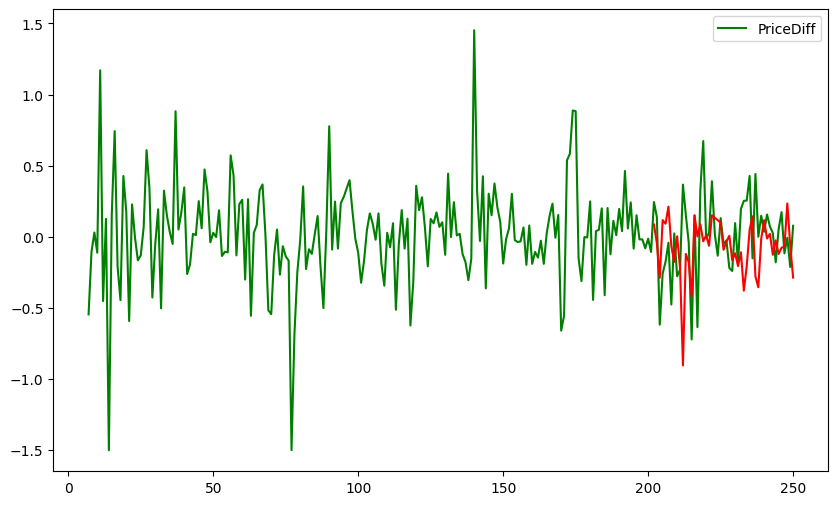

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
stock_prediction_df.plot(y='PriceDiff',color='green',ax=ax)
stock_prediction_df.loc['2016-08-01':, 'Predicted Price Diff'].plot(ax=ax, color='red', label='Predicted Price Diff')
# stock_prediction_df.plot(y='Predicted Price Diff',color='red',ax=ax)